In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy
import math
import time
%matplotlib widget

In [2]:
#C:\\Users\\jaink\\Downloads\\Logs\\Processed\\FRC_20220409_172816_CASJ_Q12.csv
df = pd.read_csv("./SVR Matches/Processed/FRC_20220408_203801_CASJ_P12.csv")

In [3]:
cols = ["NT:/SmartDashboard/HSSwerveDriveController/Theta Error", "NT:/SmartDashboard/HSSwerveDriveController/X Error"]
MAX = 10000000000000000000
MIN = -10000000000000000000

In [4]:
dfs = []
for col in cols:
    dfs.append(df.loc[df['Name'] == col])

In [5]:
vals = [[]for i in range(len(cols))]
times = [[] for i in range(len(cols))]
for df1 in range(len(dfs)):
    for i in range(len(dfs[df1])):
        vals[df1].append(float(dfs[df1].iloc[i]["Value"]))
        times[df1].append(float(dfs[df1].iloc[i]["Timestamp"]))


In [6]:
auton = None
autonRows = df.loc[df["Name"]=="DS:autonomous"]
enabledRows = df.loc[df["Name"]=="DS:enabled"]
for i in range(len(autonRows)):
    if autonRows.iloc[i]["Value"] == "true":
        auton = autonRows.iloc[i]["Timestamp"]
        break
for i in range(len(enabledRows)):
    if auton != None and enabledRows.iloc[i]["Value"] == "true":
        auton = enabledRows.iloc[i]["Timestamp"]
        break
print(auton)

131.177875


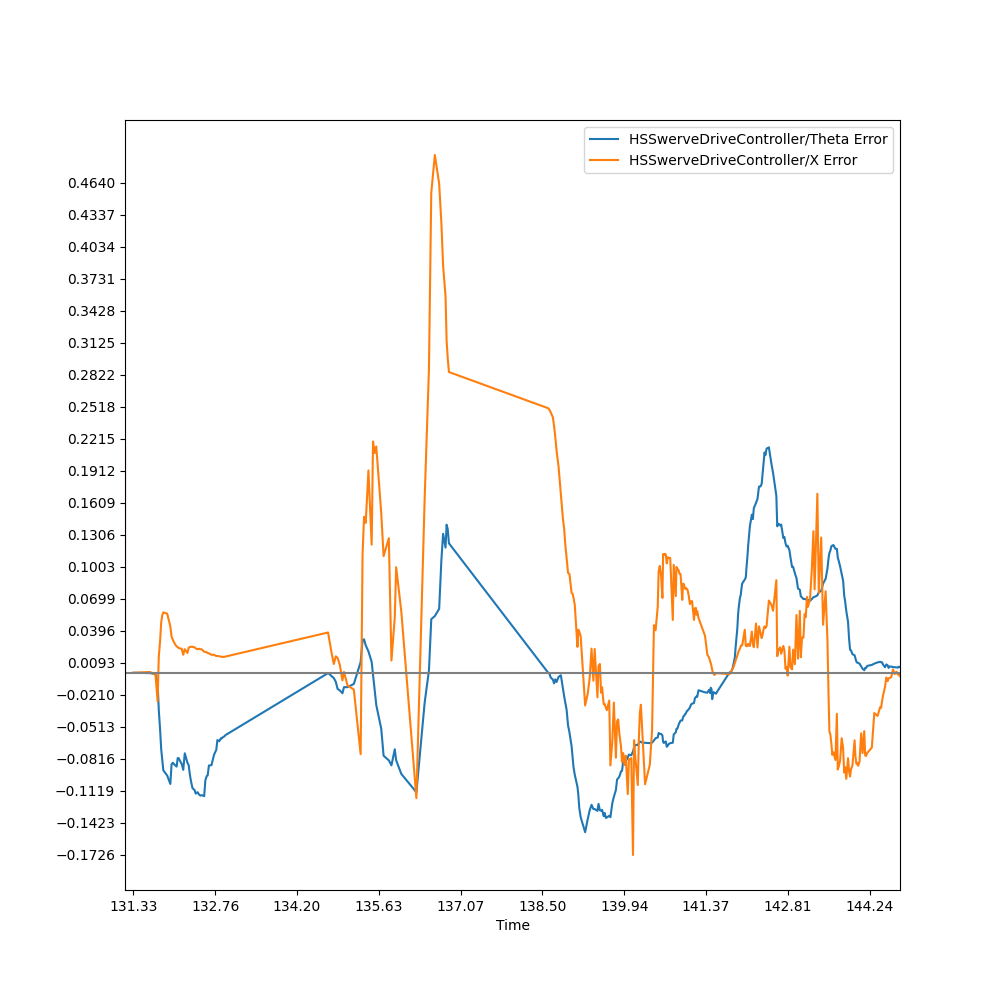

In [8]:
plt.figure(figsize=(10, 10))
for i in range(len(cols)):
    plt.plot(times[i], vals[i], label = cols[i].lstrip("NT:/SmartDashboard/") )

maxTime = MIN
minTime = MAX
maxVal = MIN
minVal = MAX
for i in range(len(cols)):
    if maxTime < max(times[i]):
        maxTime = max(times[i])
    if maxVal < max(vals[i]):
        maxVal = max(vals[i])
    if minVal > min(vals[i]):
        minVal = min(vals[i])
    if minTime > min(times[i]):
        minTime = min(times[i])

        
if timeStampMin != MAX and timeStampMax != MIN:
    plt.xticks(numpy.arange(timeStampMin, timeStampMax, (timeStampMax-timeStampMin)/len(times[0])*35))
    plt.xlim(timeStampMin, timeStampMax)
else:
    plt.xticks(numpy.arange(minTime, maxTime, (maxTime-minTime)/len(times[0])*35))
    plt.xlim(auton, maxTime)

    
if auton != None:
    plt.vlines(x=auton, ymin = min(vals[0]), ymax = max(vals[0]), color="red")

# plt.yticks(numpy.arange(minVal, maxVal, (maxVal-minVal)/len(vals[0])*15))
plt.xlabel("Time")

plt.axhline(0, color="gray")
plt.legend()
plt.show()